# Comparing Pylint Radon Across genders and request types

In [1]:
import os
import sqlite3
import pandas as pd

db_path = "../../giicg.db"
if not os.path.exists(db_path):
    raise FileNotFoundError(f"Database file does not exist: {db_path}")

conn = sqlite3.connect(db_path)
code = pd.read_sql("""SELECT
                          ps.*,
                          llm.validity_score, llm.cleanliness_score, llm.readability_score, llm.structure_score, llm.best_practices_score,
                          cp.can_you_question, cp.i_statement, cp.unpersonal_command, cp.you_command, cp.we_command, cp.unpersonal_question, cp.i_question, cp.we_question
                        FROM pylint_scores ps
                        JOIN llm_judge_COT_gpt5 llm on llm.code_reply_id = ps.code_reply_id
                        JOIN categorized_prompts cp on cp.message_id = ps.message_id
                   """, conn)
cols_to_int = [
    "validity_score",
    "cleanliness_score",
    "readability_score",
    "structure_score",
    "best_practices_score"
]
for col in cols_to_int:
    code[col] = pd.to_numeric(code[col], errors='coerce').astype('Int64')

code = code[code["message_id"] != 1524]
code = code[code["message_id"] != 764]
code = code[code['gender'].isin(['Woman (cisgender)', 'Man (cisgender)'])]


In [2]:
users_per_gender = code.groupby('gender')['user_id'].nunique()
print(users_per_gender)
num_unique_message_ids = code['message_id'].nunique()
print("Number of unique message_ids:", num_unique_message_ids)

gender
Man (cisgender)      5
Woman (cisgender)    8
Name: user_id, dtype: int64
Number of unique message_ids: 22


## Subsampling one prompt per user

In [3]:
import pandas as pd

# Step 1: Pick a single model version (any will work; here I pick the first present)
model_pick = code['model_version'].iloc[0]

# Step 2: For this model_version, group by user and count unique message_ids
counts = (code[code['model_version'] == model_pick]
          .groupby('user_id')['message_id']
          .nunique()
          .reset_index(name='n_msg'))

# Step 3: Find users who have multiple message ids with this model version
multi_message_users = counts[counts['n_msg'] > 1]['user_id']

# Step 4: For each user, keep only one message_id and mark the rest as excess
excess_message_ids = []
for user in multi_message_users:
    message_ids = code[(code['model_version'] == model_pick) & (code['user_id'] == user)]['message_id'].unique()
    #keep = pd.Series(message_ids).sample(1).item()  # pick one to keep
    keep = message_ids[1]
    # All others are excess:
    excess_ids = [mid for mid in message_ids if mid != keep]
    excess_message_ids.extend(excess_ids)

# Step 5: Filter out these excess message_ids from the full dataframe (all model_versions)
filtered_code = code[~code['message_id'].isin(excess_message_ids)].copy()


print(f"Filtered out {len(excess_message_ids)} excess message_ids.")
filtered_code

Filtered out 9 excess message_ids.


,code_reply_id,conversation_id,message_id,message_text,gender,user_id,model_reply,code,model_version,programming_language,...,structure_score,best_practices_score,can_you_question,i_statement,unpersonal_command,you_command,we_command,unpersonal_question,i_question,we_question
0,1,6,5,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,You can use `OneHotEncoder` from `sklearn.prep...,from sklearn.preprocessing import OneHotEncode...,chatgpt-4o-latest,python,...,9,9,0,1,0,0,0,0,1,0
4,6,13,126,"how to run a Python future without blocking, i...",Man (cisgender),46,You can use `task = asyncio.create_task(coro)`...,import asyncio\n\nasync def my_coro():\n pr...,chatgpt-4o-latest,python,...,9,9,0,0,0,0,0,1,0,0
5,7,15,242,hey can you write me a short python script for...,Woman (cisgender),48,Sure! Here's a short Python script you can use...,import pandas as pd\n\n# Read the CSV file\ndf...,chatgpt-4o-latest,python,...,7,8,1,0,0,0,0,0,0,0
7,9,20,268,I work with Python and have to read an NMEA fi...,Woman (cisgender),65,You can use Python to read and parse NMEA sent...,def parse_nmea_file(filename):\n with open(...,chatgpt-4o-latest,python,...,6,6,0,1,0,0,0,0,0,0
10,16,36,756,"Hi ChatGpt, given a json file with the followi...",Woman (cisgender),28,Sure! Here's **one Python script using the `re...,import os\nimport json\nimport requests\n\n# P...,chatgpt-4o-latest,python,...,6,7,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,701,47,981,I have a two point clouds where one is a subse...,Man (cisgender),81,Here's a Python function that colors a subset ...,import open3d as o3d\nimport numpy as np\n\nde...,deepseek-chat,python,...,7,8,0,1,0,0,0,0,0,0
486,703,52,1023,"i have a raw ticket like this:\n\n{\n ""...",Woman (cisgender),90,Here's a Pydantic model that can parse your ra...,"from pydantic import BaseModel, Field\nfrom ty...",deepseek-chat,python,...,9,9,1,0,0,0,0,0,0,0
487,704,55,1133,Write shortest tutorial on creating RAG on ema...,Man (cisgender),6,# Build a RAG System for Email Search\n\n## Qu...,from langchain.document_loaders import TextLoa...,deepseek-chat,python,...,7,7,0,0,0,1,0,0,0,0
489,707,66,1464,Please write down a jit-eable gradient of this...,Man (cisgender),77,Here's a jit-eable gradient function for your ...,"import jax.numpy as jnp\nfrom jax import jit, ...",deepseek-chat,python,...,7,8,0,0,0,1,0,0,0,0


In [4]:
users_per_gender = filtered_code.groupby('gender')['user_id'].nunique()
print(users_per_gender)
num_unique_message_ids = filtered_code['message_id'].nunique()
print("Number of unique message_ids:", num_unique_message_ids)


gender
Man (cisgender)      5
Woman (cisgender)    8
Name: user_id, dtype: int64
Number of unique message_ids: 13


## Aggregate scores over the three model runs

In [5]:
import pandas as pd

# List of columns to aggregate using mean and std
agg_cols = [
    "radon_complexity",
    "radon_maintainability_index",
    "radon_loc",
    "radon_sloc",
    "radon_lloc",
    "radon_comments",
    "pylint_score",
    "validity_score",
    "cleanliness_score",
    "readability_score",
    "structure_score",
    "best_practices_score"
]

# Define aggregation dictionary for mean and std, ignore NaNs automatically
agg_dict = {}
for col in agg_cols:
    agg_dict[col] = ['mean', 'std']

# Group by the required columns
group_cols = [
    "conversation_id",
    "message_id",
    "message_text",
    "gender",
    "user_id",
    "model_version",
    "can_you_question",
    "i_statement",
    "unpersonal_command",
    "you_command",
    "we_command",
    "unpersonal_question",
    "i_question",
    "we_question"
]

# Perform aggregation for subsampled dataframe (for gender comparison)
agg_df_subsampled = (
    filtered_code
    .groupby(group_cols, dropna=False)
    .agg(agg_dict)
    .reset_index()
)

# Flatten column multi-index
agg_df_subsampled.columns = [
    f"{col if stat == '' else stat + '_' + col}" if stat != '' else col
    for col, stat in agg_df_subsampled.columns.to_flat_index()
]

# Move mean_/std_ to correct suffix format: mean_colname, std_colname
agg_df_subsampled = agg_df_subsampled.rename(columns={f"mean_{col}": f"mean_{col}" for col in agg_cols})
agg_df_subsampled = agg_df_subsampled.rename(columns={f"std_{col}": f"std_{col}" for col in agg_cols})

# Perform aggregation for original dataframe (for request type comparison)
agg_df = (
    code
    .groupby(group_cols, dropna=False)
    .agg(agg_dict)
    .reset_index()
)

# Flatten column multi-index
agg_df.columns = [
    f"{col if stat == '' else stat + '_' + col}" if stat != '' else col
    for col, stat in agg_df.columns.to_flat_index()
]

# Move mean_/std_ to correct suffix format: mean_colname, std_colname
agg_df = agg_df.rename(columns={f"mean_{col}": f"mean_{col}" for col in agg_cols})
agg_df = agg_df.rename(columns={f"std_{col}": f"std_{col}" for col in agg_cols})

agg_df_subsampled

,conversation_id,message_id,message_text,gender,user_id,model_version,can_you_question,i_statement,unpersonal_command,you_command,...,mean_validity_score,std_validity_score,mean_cleanliness_score,std_cleanliness_score,mean_readability_score,std_readability_score,mean_structure_score,std_structure_score,mean_best_practices_score,std_best_practices_score
0,6,5,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,chatgpt-4o-latest,0,1,0,0,...,10.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0
1,6,5,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,claude-3-7-sonnet-20250219,0,1,0,0,...,9.0,0.0,8.666667,0.57735,9.0,0.0,9.0,0.0,9.0,0.0
2,6,5,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,claude-sonnet-4-20250514,0,1,0,0,...,8.333333,1.154701,8.666667,0.57735,8.666667,0.57735,8.666667,0.57735,8.333333,1.154701
3,6,5,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,deepseek-chat,0,1,0,0,...,9.0,0.0,9.0,0.0,8.666667,0.57735,8.666667,0.57735,9.0,0.0
4,6,5,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,gpt-4.1-2025-04-14,0,1,0,0,...,10.0,0.0,9.0,0.0,9.0,0.0,8.666667,0.57735,9.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,72,1534,can you write me some python code to count the...,Woman (cisgender),11,claude-sonnet-4-20250514,1,0,0,0,...,9.333333,0.57735,8.666667,0.57735,8.333333,0.57735,8.0,1.0,8.666667,0.57735
87,72,1534,can you write me some python code to count the...,Woman (cisgender),11,deepseek-chat,1,0,0,0,...,10.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0
88,72,1534,can you write me some python code to count the...,Woman (cisgender),11,gpt-4.1-2025-04-14,1,0,0,0,...,9.666667,0.57735,9.0,0.0,8.666667,0.57735,9.0,0.0,9.0,0.0
89,72,1534,can you write me some python code to count the...,Woman (cisgender),11,gpt-5-chat-latest,1,0,0,0,...,10.0,0.0,9.666667,0.57735,9.666667,0.57735,9.666667,0.57735,9.666667,0.57735


## Gender

In [12]:
from helpers.statistical_tests_new import compare_groups
from statsmodels.stats.multitest import multipletests


def groupwise_comparison_with_correction(df, columns, one_sided=False, direction="greater"):
    stat_vals = []
    dfs = []
    p_vals = []
    test_types = []
    directions = []
    one_sideds = []
    female_means = []
    male_means = []
    female_stds = []
    male_stds = []
    n_females = []
    n_males = []
    nonzero_females = []
    nonzero_males = []
    effsizes = []
    effsize_types = []
    cis = []
    for col in columns:
        result = compare_groups(df, col,group_column="gender", group_x="Man (cisgender)", group_y="Woman (cisgender)", one_sided=one_sided, direction=direction)
        stat_vals.append(result['test_statistic'])
        dfs.append(result['df'])
        p_vals.append(result['p_value'])
        test_types.append(result['test_type'])
        directions.append(result['direction'])
        one_sideds.append(result['one_sided'])
        female_means.append(result['mean_y'])
        male_means.append(result['mean_x'])
        female_stds.append(result['std_y'])
        male_stds.append(result['std_x'])
        n_females.append(result['n_y'])
        n_males.append(result['n_x'])
        nonzero_females.append(result['hits_y'])
        nonzero_males.append(result['hits_x']),
        effsizes.append(result['effect_size']),
        effsize_types.append(result['effect_size_type'])
        cis.append(result['effect_size_CI'])
    reject, pvals_corrected, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')

    results = pd.DataFrame({
        'word': columns,
        'test type': test_types,
        'direction': directions,
        'one_sided': one_sideds,
        'df': dfs,
        'stat_value': stat_vals,
        'p_value': p_vals,
        'corrected p_value': pvals_corrected,
        'mean_f': female_means,
        'mean_m': male_means,
        'std_f': female_stds,
        'std_m': male_stds,
        'n_f': n_females,
        'n_m': n_males,
        'n_hits_f': nonzero_females,
        'n_hits_m': nonzero_males,
        'effsize': effsizes,
        'effsize_type': effsize_types,
        'ci': cis,
    })
    return results

In [13]:
test_cols =  [
    "mean_radon_complexity",
    "mean_radon_maintainability_index",
    "mean_radon_loc",
    "mean_radon_sloc",
    "mean_radon_lloc",
    "mean_radon_comments",
    "mean_pylint_score",
    "mean_validity_score",
    "mean_cleanliness_score",
    "mean_readability_score",
    "mean_structure_score",
    "mean_best_practices_score"
]

results_gender = []
for model, group in agg_df_subsampled.groupby("model_version"):
    result = groupwise_comparison_with_correction(group, test_cols)
    result['model_version'] = model
    results_gender.append(result)

final_gender = pd.concat(results_gender, axis=0)

final_gender

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci,model_version
0,mean_radon_complexity,Fisher's exact,greater,False,NaN,inf,0.043512,0.245868,NaN,NaN,NaN,NaN,NaN,NaN,3,5,inf,Odds ratio,None,chatgpt-4o-latest
1,mean_radon_maintainability_index,Mann-Whitney U,greater,False,NaN,9.000000,0.094733,0.245868,100.000000,92.754236,6.896492,12.244982,8.0,5.0,8,5,-0.550000,RBC,"[-1.0, 0.09]",chatgpt-4o-latest
2,mean_radon_loc,T-test,two-sided,False,5.538294,1.755742,0.133769,0.267539,20.833333,34.800000,8.962001,16.315637,8.0,5.0,8,5,1.148398,Cohen's d,"[-0.15, 2.8]",chatgpt-4o-latest
3,mean_radon_sloc,T-test,two-sided,False,6.164870,1.483506,0.187171,0.280756,14.583333,22.666667,7.068261,10.826921,8.0,5.0,8,5,0.937018,Cohen's d,"[-0.17, 2.14]",chatgpt-4o-latest
4,mean_radon_lloc,T-test,two-sided,False,7.284789,2.014635,0.082201,0.245868,12.416667,20.933333,6.470323,7.949144,8.0,5.0,8,5,1.209052,Cohen's d,"[0.08, 2.67]",chatgpt-4o-latest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,mean_validity_score,Mann-Whitney U,greater,False,NaN,14.500000,0.369369,0.592175,9.000000,9.000000,0.527046,0.596285,8.0,5.0,8,5,-0.275000,RBC,"[-0.7, 0.12]",o3-2025-04-16
8,mean_cleanliness_score,Mann-Whitney U,greater,False,NaN,8.000000,0.065464,0.392781,9.000000,8.666667,0.248008,1.069787,8.0,5.0,8,5,-0.600000,RBC,"[-1.0, -0.07]",o3-2025-04-16
9,mean_readability_score,T-test,two-sided,False,4.741282,-0.906364,0.408443,0.592175,8.458333,8.066667,0.353553,0.924962,8.0,5.0,8,5,-0.626641,Cohen's d,"[-2.12, 1.05]",o3-2025-04-16
10,mean_structure_score,Mann-Whitney U,greater,False,NaN,25.500000,0.444131,0.592175,8.333333,8.666667,0.235702,1.260511,8.0,5.0,8,5,0.275000,RBC,"[-0.55, 0.92]",o3-2025-04-16


### to latex

In [14]:
from helpers.make_latex_table import create_latex_tables

for model_df in results_gender:
    model = model_df['model_version'].iloc[0]
    create_latex_tables(model_df, f"{model}_gender_stats", f"{model}_gender_hits")


### count trends across models

In [31]:
import pandas as pd

def get_significant_rows(results):
    tmp = []
    for df in results:
        sig_rows = df[df["corrected p_value"] < 0.05].copy()
        tmp.append(sig_rows)
    return pd.concat(tmp, ignore_index=True)


def count_direction(group):
    positive = group[group['stat_value'] > 0]['model_version'].unique()
    negative = group[group['stat_value'] < 0]['model_version'].unique()
    return pd.Series({
        'count_stat_pos': len(positive),
        'models_stat_pos': list(positive),
        'count_stat_neg': len(negative),
        'models_stat_neg': list(negative)
    })

# Group by your metric/word and apply
tmp_df = get_significant_rows(results_gender)


counts = (
    tmp_df.groupby('word')
    .apply(count_direction)
    .reset_index()
    .rename(columns={'word': 'metric'})
)

counts

/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_31509/622394423.py:27: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(count_direction)


,metric,count_stat_pos,models_stat_pos,count_stat_neg,models_stat_neg
0,mean_radon_comments,1,[claude-3-7-sonnet-20250219],0,[]


## Request Type (direct vs indirect)

### aggregate request types into direct/indirect

- direct: unpersonal_command, you_command, unpersonal_question
- indirect: can you question, i statement, we command, i question, we question

In [15]:
users_per_gender_agg = code.groupby('gender')['user_id'].nunique()
print(users_per_gender_agg)
num_unique_message_ids_agg = agg_df['message_id'].nunique()
print("Number of unique message_ids:", num_unique_message_ids_agg)

gender
Man (cisgender)      5
Woman (cisgender)    8
Name: user_id, dtype: int64
Number of unique message_ids: 22


In [16]:
direct_cols = ["unpersonal_command", "you_command", "unpersonal_question"]
indirect_cols = ["can_you_question", "i_statement", "we_command", "i_question", "we_question"]

#direct_cols = ["unpersonal_command", "you_command", "unpersonal_question"]
#indirect_cols = ["can_you_question", "we_command", "we_question"]

def annotate_directness(row):
    num_direct = sum([row[col] for col in direct_cols])
    num_indirect = sum([row[col] for col in indirect_cols])
    if num_direct > num_indirect:
        return "direct"
    elif num_indirect > num_direct:
        return "indirect"
    elif num_direct == num_indirect:
        # Tie goes to direct, even if both zeros
        return "direct"
    else:
        # Fallback (shouldn't happen)
        return "direct"

agg_df["directness"] = agg_df.apply(annotate_directness, axis=1)
agg_df

,conversation_id,message_id,message_text,gender,user_id,model_version,can_you_question,i_statement,unpersonal_command,you_command,...,std_validity_score,mean_cleanliness_score,std_cleanliness_score,mean_readability_score,std_readability_score,mean_structure_score,std_structure_score,mean_best_practices_score,std_best_practices_score,directness
0,6,5,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,chatgpt-4o-latest,0,1,0,0,...,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,indirect
1,6,5,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,claude-3-7-sonnet-20250219,0,1,0,0,...,0.0,8.666667,0.57735,9.0,0.0,9.0,0.0,9.0,0.0,indirect
2,6,5,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,claude-sonnet-4-20250514,0,1,0,0,...,1.154701,8.666667,0.57735,8.666667,0.57735,8.666667,0.57735,8.333333,1.154701,indirect
3,6,5,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,deepseek-chat,0,1,0,0,...,0.0,9.0,0.0,8.666667,0.57735,8.666667,0.57735,9.0,0.0,indirect
4,6,5,I want to use Dummy Hot encoding to replace th...,Woman (cisgender),16,gpt-4.1-2025-04-14,0,1,0,0,...,0.0,9.0,0.0,9.0,0.0,8.666667,0.57735,9.0,0.0,indirect
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,86,1664,how to merge multiple xarray under a new categ...,Woman (cisgender),60,claude-sonnet-4-20250514,0,0,0,0,...,0.57735,9.0,0.0,9.0,0.0,8.666667,0.57735,9.0,0.0,direct
149,86,1664,how to merge multiple xarray under a new categ...,Woman (cisgender),60,deepseek-chat,0,0,0,0,...,0.0,8.0,0.0,8.0,0.0,8.0,0.0,8.0,0.0,direct
150,86,1664,how to merge multiple xarray under a new categ...,Woman (cisgender),60,gpt-4.1-2025-04-14,0,0,0,0,...,2.516611,8.0,1.732051,7.666667,1.527525,7.666667,1.527525,7.333333,2.081666,direct
151,86,1664,how to merge multiple xarray under a new categ...,Woman (cisgender),60,gpt-5-chat-latest,0,0,0,0,...,1.732051,8.333333,0.57735,8.333333,0.57735,8.333333,0.57735,8.666667,0.57735,direct


In [28]:
# import matplotlib.pyplot as plt
# import seaborn as sns
#
# # 1. Pick the first model_version group
# first_model_version = agg_df["model_version"].unique()[0]
# df_subset = agg_df[agg_df["model_version"] == first_model_version].copy()
#
#
# # 2. Calculate rates per user+gender for each type
# grouped = (
#     df_subset
#     .groupby(["gender", "directness_label"])
#     .size()
#     .reset_index(name='count')
# )
#
# # 3. Calculate total prompts per user
# total_prompts = (
#     grouped.groupby(["gender"])["count"]
#     .sum().reset_index(name='total')
# )
#
# # 4. Merge and compute rates
# merged = grouped.merge(total_prompts, on=["gender"])
# merged["rate"] = merged["count"] / merged["total"]
#
# # 5. Plot
# plt.figure(figsize=(8,5))
# sns.barplot(
#     data=merged,
#     x="gender",
#     y="rate",
#     hue="directness_label"
# )
# plt.title(f"Rate of Direct vs Indirect Prompts per Gender ({first_model_version})")
# plt.xlabel("Gender")
# plt.ylabel("Prompt Rate")
# plt.legend(title="Directness")
# plt.tight_layout()
# plt.show()
#
# total_prompts


In [22]:
def groupwise_comparison_with_correction_directness(df, columns, one_sided=False, direction="greater"):
    stat_vals = []
    dfs = []
    p_vals = []
    test_types = []
    directions = []
    one_sideds = []
    female_means = []
    male_means = []
    female_stds = []
    male_stds = []
    n_females = []
    n_males = []
    nonzero_females = []
    nonzero_males = []
    effsizes = []
    effsize_types = []
    cis = []
    for col in columns:
        result = compare_groups(df, col,group_column="directness", group_x="direct", group_y="indirect", one_sided=one_sided, direction=direction)
        stat_vals.append(result['test_statistic'])
        dfs.append(result['df'])
        p_vals.append(result['p_value'])
        test_types.append(result['test_type'])
        directions.append(result['direction'])
        one_sideds.append(result['one_sided'])
        female_means.append(result['mean_y'])
        male_means.append(result['mean_x'])
        female_stds.append(result['std_y'])
        male_stds.append(result['std_x'])
        n_females.append(result['n_y'])
        n_males.append(result['n_x'])
        nonzero_females.append(result['hits_y'])
        nonzero_males.append(result['hits_x']),
        effsizes.append(result['effect_size']),
        effsize_types.append(result['effect_size_type'])
        cis.append(result['effect_size_CI'])
    reject, pvals_corrected, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')

    results = pd.DataFrame({
        'word': columns,
        'test type': test_types,
        'direction': directions,
        'one_sided': one_sideds,
        'df': dfs,
        'stat_value': stat_vals,
        'p_value': p_vals,
        'corrected p_value': pvals_corrected,
        'mean_f': female_means,
        'mean_m': male_means,
        'std_f': female_stds,
        'std_m': male_stds,
        'n_f': n_females,
        'n_m': n_males,
        'n_hits_f': nonzero_females,
        'n_hits_m': nonzero_males,
        'effsize': effsizes,
        'effsize_type': effsize_types,
        'ci': cis,
    })
    return results


In [23]:
test_cols =  [
    "mean_radon_complexity",
    "mean_radon_maintainability_index",
    "mean_radon_loc",
    "mean_radon_sloc",
    "mean_radon_lloc",
    "mean_radon_comments",
    "mean_pylint_score",
    "mean_validity_score",
    "mean_cleanliness_score",
    "mean_readability_score",
    "mean_structure_score",
    "mean_best_practices_score"
]

results = []
for model, group in agg_df.groupby("model_version"):
    result = groupwise_comparison_with_correction_directness(group, test_cols)
    result['model_version'] = model
    results.append(result)

final_directness = pd.concat(results, axis=0)

final_directness

,word,test type,direction,one_sided,df,stat_value,p_value,corrected p_value,mean_f,mean_m,std_f,std_m,n_f,n_m,n_hits_f,n_hits_m,effsize,effsize_type,ci,model_version
0,mean_radon_complexity,Mann-Whitney U,greater,False,NaN,76.000000,0.300225,0.514672,0.000000,1.000000,1.696104,1.193657,11.0,11.0,4,8,0.256198,RBC,"[-0.28, 0.7]",chatgpt-4o-latest
1,mean_radon_maintainability_index,Mann-Whitney U,greater,False,NaN,39.500000,0.141547,0.424640,100.000000,92.754236,5.859770,12.085056,11.0,11.0,11,11,-0.347107,RBC,"[-0.75, 0.12]",chatgpt-4o-latest
2,mean_radon_loc,T-test,two-sided,False,13.970660,2.040946,0.060619,0.366543,20.212121,35.969697,10.605316,23.307345,11.0,11.0,11,11,0.870262,Cohen's d,"[0.11, 1.81]",chatgpt-4o-latest
3,mean_radon_sloc,T-test,two-sided,False,15.232186,2.022121,0.061090,0.366543,12.878788,23.424242,8.117570,15.273136,11.0,11.0,11,11,0.862236,Cohen's d,"[0.1, 1.7]",chatgpt-4o-latest
4,mean_radon_lloc,T-test,two-sided,False,15.429810,1.731630,0.103279,0.413116,12.121212,19.969697,7.175998,13.208965,11.0,11.0,11,11,0.738370,Cohen's d,"[-0.11, 1.63]",chatgpt-4o-latest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,mean_validity_score,Mann-Whitney U,greater,False,NaN,55.500000,0.739448,0.881835,9.000000,9.000000,0.479899,0.477790,11.0,11.0,11,11,-0.082645,RBC,"[-0.52, 0.33]",o3-2025-04-16
8,mean_cleanliness_score,Mann-Whitney U,greater,False,NaN,50.000000,0.488024,0.732036,9.000000,8.666667,0.416818,0.807790,11.0,11.0,11,11,-0.173554,RBC,"[-0.61, 0.26]",o3-2025-04-16
9,mean_readability_score,Mann-Whitney U,greater,False,NaN,68.000000,0.637570,0.850093,8.666667,8.666667,0.449467,0.716332,11.0,11.0,11,11,0.123967,RBC,"[-0.37, 0.58]",o3-2025-04-16
10,mean_structure_score,Mann-Whitney U,greater,False,NaN,61.000000,1.000000,1.000000,8.333333,8.666667,0.404520,0.849242,11.0,11.0,11,11,0.008264,RBC,"[-0.48, 0.48]",o3-2025-04-16


### to latex

In [24]:
for model_df_directness in results:
    model = model_df_directness['model_version'].iloc[0]
    create_latex_tables(model_df_directness, f"{model}_directness_stats", f"{model}_directness_hits")

## Correlate Pylint Score and LLM as Judge

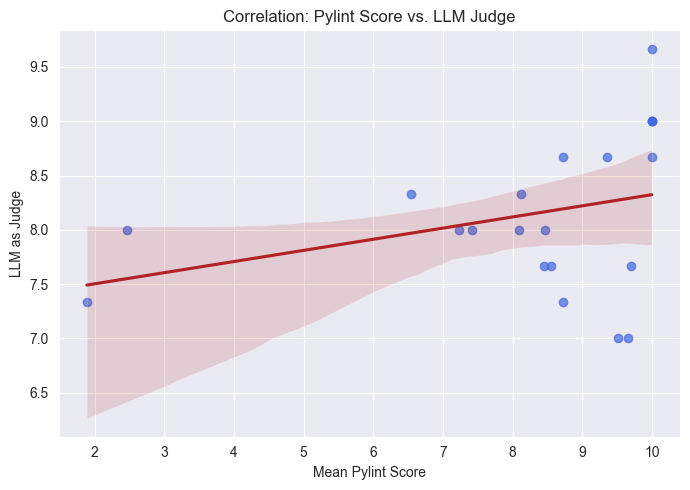

In [14]:
gpt5_df = agg_df[agg_df['model_version'] == 'claude-sonnet-4-20250514']
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,5))
sns.regplot(
    data=gpt5_df,
    x="mean_pylint_score",
    y="mean_readability_score",
    scatter_kws={'alpha': 0.7, 'color': 'royalblue'},
    line_kws={'color': 'firebrick'}
)
plt.xlabel("Mean Pylint Score")
plt.ylabel("LLM as Judge")
plt.title("Correlation: Pylint Score vs. LLM Judge")
plt.tight_layout()
plt.show()